In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Fish.csv')

In [3]:
df.head()

Species  Weight  VerticalLen  DiagonalLen  CrossLen   Height   Width
0   Bream   242.0         23.2         25.4      30.0  11.5200  4.0200
1   Bream   290.0         24.0         26.3      31.2  12.4800  4.3056
2   Bream   340.0         23.9         26.5      31.1  12.3778  4.6961
3   Bream   363.0         26.3         29.0      33.5  12.7300  4.4555
4   Bream   430.0         26.5         29.0      34.0  12.4440  5.1340

In [4]:
columns = {'VerticalLen':'v_length', 'DiagonalLen':'diag_length', 'CrossLen':'cross_length'}
df.rename(columns=columns, inplace=True)
df.columns = df.columns.str.lower()

Label Encoding

In [5]:
df['species_coding'] = df['species'].astype('category').cat.codes

In [6]:
df

species  weight  v_length  diag_length  cross_length   height   width  \
0     Bream   242.0      23.2         25.4          30.0  11.5200  4.0200   
1     Bream   290.0      24.0         26.3          31.2  12.4800  4.3056   
2     Bream   340.0      23.9         26.5          31.1  12.3778  4.6961   
3     Bream   363.0      26.3         29.0          33.5  12.7300  4.4555   
4     Bream   430.0      26.5         29.0          34.0  12.4440  5.1340   
..      ...     ...       ...          ...           ...      ...     ...   
154   Smelt    12.2      11.5         12.2          13.4   2.0904  1.3936   
155   Smelt    13.4      11.7         12.4          13.5   2.4300  1.2690   
156   Smelt    12.2      12.1         13.0          13.8   2.2770  1.2558   
157   Smelt    19.7      13.2         14.3          15.2   2.8728  2.0672   
158   Smelt    19.9      13.8         15.0          16.2   2.9322  1.8792   

     species_coding  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
154               5  
155               5  
156               5  
157               5  
158               5  

[159 rows x 8 columns]

Text(0.5, 0.98, 'Relationship between Weight and Variables')

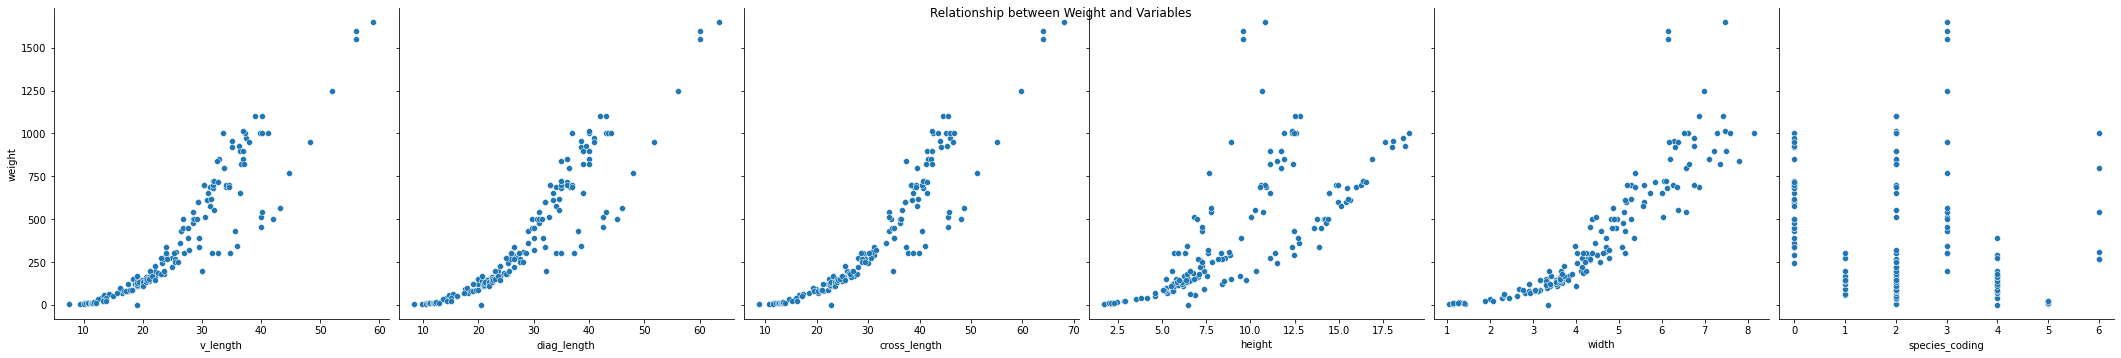

In [7]:
rel = sns.pairplot(df, x_vars=df.columns[2:], y_vars=['weight'], height=5)
rel.fig.suptitle('Relationship between Weight and Variables')

In [8]:
df[df['weight'] > 1400]

species  weight  v_length  diag_length  cross_length  height  width  \
142    Pike  1600.0      56.0         60.0          64.0   9.600  6.144   
143    Pike  1550.0      56.0         60.0          64.0   9.600  6.144   
144    Pike  1650.0      59.0         63.4          68.0  10.812  7.480   

     species_coding  
142               3  
143               3  
144               3

A few samples with label code 3 (Pike) have extremely high values of weight which can be considered as outliers. As these samples account for only 1.9% of total samples (3/159), I'll remove them from training.

In [9]:
new_df = df[df['weight'] <= 1400]

### Build Linear Regression model

In [113]:
# Create function to train model in Linear Regression
def feature_norminalization(f_matrix):
    '''
    Use min-max norminalization
    Each column represents a feature
    '''
    mean = np.mean(f_matrix, axis=0)
    min = np.min(f_matrix, axis=0)
    max = np.max(f_matrix, axis=0)

    result = f_matrix
    for i in range(f_matrix.shape[1]):
        result[:,i] = (f_matrix[:,i] - mean[i]) / (max[i] - min[i])
        
    return result, mean, max, min

class LinearRegression:
    def __init__(self, X_data, y_target, learning_rate=0.001, num_epochs=1000):
        self.X_data = X_data
        self.y_target = y_target
        self.learning_rate = learning_rate
        self.n_samples = self.X_data.shape[0]
        self.n_features = self.X_data.shape[1]
        self.num_epochs = num_epochs

        self.theta = np.random.normal(size=(self.n_features))
        self.losses = []

    def predict(self, X_data, theta):
        y_pred = X_data.dot(theta)
        return y_pred
    
    def compute_loss(self, y_target, y_pred):
        avg_loss = np.mean((y_target - y_pred)**2)
        return avg_loss
    
    def fit(self):
        for epoch in range(self.num_epochs):
            # compute y_pred
            y_pred = self.predict(self.X_data, self.theta)

            # compute loss
            loss = self.compute_loss(self.y_target, y_pred)
            self.losses.append(loss)

            # compute gradient
            k = 2*(y_pred - self.y_target).reshape(self.n_samples, 1)
            dloss = np.mean(k*self.X_data, axis=0)

            # update theta
            self.theta = self.theta - self.learning_rate*dloss

            print(f'epoch: {epoch} - loss: {loss}')
        
        return self.theta, self.losses, y_pred
    
def output_predict(weight, mean_train, max_train, min_train, input_data):
    x = input_data
    for i in range(input_data.shape[1]):
        x[:,i] = (input_data[:,i] - mean_train[i]) / (max_train[i] - min_train[i])
    x = np.c_[np.ones((x.shape[0], 1)), x]
    y = x.dot(weight)
    return y

def r2score(y_target, X_data, y_pred):
    rss = np.sum((y_target - y_pred)**2)
    tss = np.sum((y_target - np.mean(y_target))**2)

    return (1 - rss/tss)

def plot_loss(losses):
    N = len(losses)
    plt.plot(list(range(N)), losses, color='red')
    plt.xlabel('#epoch')
    plt.ylabel('MSE')        


In [11]:
# Prepare input feature
def feature_matrix(matrix):
    n_samples = matrix.shape[0]
    result = np.c_[np.ones((n_samples,1)), matrix]
    return result

In [12]:
X_data = np.array(new_df.iloc[:,2:])
y_target = np.array(new_df.iloc[:,1])

### Use **Multivariate Linear Regression** to train model

In [13]:
norminalize_X_data = feature_matrix(feature_norminalization(X_data)[0])

In [114]:
LR = LinearRegression(X_data=norminalize_X_data, y_target=y_target, learning_rate=0.9)
weight, losses, y_pred = LR.fit()

epoch: 0 - loss: 242241.99742151736
epoch: 1 - loss: 133141.18648571087
epoch: 2 - loss: 81311.60003408839
epoch: 3 - loss: 53821.848247473106
epoch: 4 - loss: 37975.759245298585
epoch: 5 - loss: 28333.663235005515
epoch: 6 - loss: 22273.11416160529
epoch: 7 - loss: 18388.947986089504
epoch: 8 - loss: 15867.599636482719
epoch: 9 - loss: 14214.391119908783
epoch: 10 - loss: 13119.897594461909
epoch: 11 - loss: 12387.474184555102
epoch: 12 - loss: 11891.003248603329
epoch: 13 - loss: 11549.132130408312
epoch: 14 - loss: 11309.160272712601
epoch: 15 - loss: 11136.819693487538
epoch: 16 - loss: 11009.742905097062
epoch: 17 - loss: 10913.26859024121
epoch: 18 - loss: 10837.74006489558
epoch: 19 - loss: 10776.760937557923
epoch: 20 - loss: 10726.066192986242
epoch: 21 - loss: 10682.789779992761
epoch: 22 - loss: 10644.988140961115
epoch: 23 - loss: 10611.329273938336
epoch: 24 - loss: 10580.88908668679
epoch: 25 - loss: 10553.017466012696
epoch: 26 - loss: 10527.249776284207
epoch: 27 - loss

In [129]:
r2_LR = r2score(y_target, norminalize_X_data, y_pred)

### Use **Multivariable Polynomial Non-linear Regression** with **Simple Approach** to train model

Prediction from Non-linear Regression model is still *linear in parameters* but *nonlinear in features*

In [16]:
def new_feature_simple(X_data, degree):
    n_samples = X_data.shape[0]
    new_matrix = X_data
    for i in range(2, degree+1):
        matrix_power = np.power(X_data, i)
        new_matrix = np.c_[new_matrix, matrix_power]
    return new_matrix

In [17]:
simple_multi_nonlinear_2 = feature_matrix(feature_norminalization(new_feature_simple(X_data=X_data, degree=2))[0])

In [116]:
simple_multi_nonlinear_2_model = LinearRegression(X_data=simple_multi_nonlinear_2, y_target=y_target, learning_rate=0.9, num_epochs=1000)
simple_weight_degree_2, simple_losses_degree_2, y_pred_simple_2 = simple_multi_nonlinear_2_model.fit()

epoch: 0 - loss: 243369.92813903285
epoch: 1 - loss: 106139.11561504257
epoch: 2 - loss: 67512.52210017208
epoch: 3 - loss: 45392.249884000164
epoch: 4 - loss: 31350.327468762305
epoch: 5 - loss: 22339.435762471578
epoch: 6 - loss: 16538.046687021375
epoch: 7 - loss: 12789.629438328375
epoch: 8 - loss: 10355.791415924368
epoch: 9 - loss: 8764.701243608386
epoch: 10 - loss: 7714.6988989403635
epoch: 11 - loss: 7012.8037021719265
epoch: 12 - loss: 6535.466311502272
epoch: 13 - loss: 6203.511553324718
epoch: 14 - loss: 5966.136997955184
epoch: 15 - loss: 5790.691681296083
epoch: 16 - loss: 5656.145026300751
epoch: 17 - loss: 5548.912219735401
epoch: 18 - loss: 5460.184709395655
epoch: 19 - loss: 5384.222300103452
epoch: 20 - loss: 5317.259774558229
epoch: 21 - loss: 5256.806363589768
epoch: 22 - loss: 5201.196451237237
epoch: 23 - loss: 5149.301024688515
epoch: 24 - loss: 5100.342031976199
epoch: 25 - loss: 5053.772669441534
epoch: 26 - loss: 5009.199948759276
epoch: 27 - loss: 4966.33441

In [130]:
r2_nLR_simple_2 = r2score(y_target, simple_multi_nonlinear_2, y_pred_simple_2)

In [20]:
simple_multi_nonlinear_3 = feature_matrix(feature_norminalization(new_feature_simple(X_data=X_data, degree=3))[0])

In [118]:
simple_multi_nonlinear_3_model = LinearRegression(X_data=simple_multi_nonlinear_3, y_target=y_target, learning_rate=0.99, num_epochs=1000)
simple_weight_degree_3, simple_losses_degree_3, y_pred_simple_3 = simple_multi_nonlinear_3_model.fit()

epoch: 0 - loss: 243073.98097363467
epoch: 1 - loss: 145060.89782531752
epoch: 2 - loss: 136942.9722701431
epoch: 3 - loss: 130896.61542182346
epoch: 4 - loss: 125438.21143669132
epoch: 5 - loss: 120354.02024344262
epoch: 6 - loss: 115549.73367880829
epoch: 7 - loss: 110977.84984786574
epoch: 8 - loss: 106611.61676510832
epoch: 9 - loss: 102433.85660394783
epoch: 10 - loss: 98432.07374552643
epoch: 11 - loss: 94596.25907555791
epoch: 12 - loss: 90917.8651971386
epoch: 13 - loss: 87389.30012059929
epoch: 14 - loss: 84003.65770794182
epoch: 15 - loss: 80754.56130059298
epoch: 16 - loss: 77636.06494335142
epoch: 17 - loss: 74642.58621657453
epoch: 18 - loss: 71768.85784646193
epoch: 19 - loss: 69009.89130556199
epoch: 20 - loss: 66360.94852532897
epoch: 21 - loss: 63817.51933512522
epoch: 22 - loss: 61375.30306669427
epoch: 23 - loss: 59030.19325454175
epoch: 24 - loss: 56778.26467569446
epoch: 25 - loss: 54615.76218231247
epoch: 26 - loss: 52539.090926727244
epoch: 27 - loss: 50544.80768

In [131]:
r2_nLR_simple_3 = r2score(y_target, simple_multi_nonlinear_3, y_pred_simple_3)

### Use **Multivariable Polynomial Non-linear Regression** with **Advanced Approach** to train model

In [96]:
def new_feature_simple(X_data, degree):
    n_features = X_data.shape[1]
    degree_arr = np.arange(degree + 1).reshape(1,-1)
    
    # Create a matrix of all possible power combinations
    power_combinations = np.ones((1, (degree+1)**n_features))
    for i in range(n_features-1, -1, -1):
        line = np.tile(np.repeat(degree_arr, (degree+1)**i, axis=1), (degree+1)**(n_features - 1 - i))
        power_combinations = np.r_[power_combinations, line]
        
    power_combinations = power_combinations[1:,:]
    power_combinations = power_combinations[:, np.where((np.sum(power_combinations, axis=0) > 0) & (np.sum(power_combinations, axis=0) <= degree))]
        
    power_combinations = power_combinations.reshape(n_features, -1).transpose()

    # Create new feature combinations from above power matrix
    new_features = np.ones((X_data.shape[0], 1))
    for i in range(power_combinations.shape[0]):
        feature = X_data.dot(power_combinations[i:i+1,:].transpose())
        new_features = np.c_[new_features, feature]

    # Normalization
    normalized_new_features, mean, max, min = feature_norminalization(new_features[:, 1:])
    normalized_new_features = np.c_[np.ones((X_data.shape[0], 1)), normalized_new_features]

    return normalized_new_features, mean, max, min

In [99]:
advanced_multi_nonlinear_2, mean, max, min = new_feature_simple(X_data, degree=2)

In [120]:
advanced_multi_nonlinear_2_model = LinearRegression(X_data=advanced_multi_nonlinear_2, y_target=y_target, learning_rate=0.95, num_epochs=1000)
advanced_weight_degree_2, advanced_losses_degree_2, y_pred_advanced_2 = advanced_multi_nonlinear_2_model.fit()

epoch: 0 - loss: 241166.99226064148
epoch: 1 - loss: 200927.39751421878
epoch: 2 - loss: 168338.0823215949
epoch: 3 - loss: 141495.94767320043
epoch: 4 - loss: 119309.246744503
epoch: 5 - loss: 100947.25358139626
epoch: 6 - loss: 85736.94963820666
epoch: 7 - loss: 73126.67193768096
epoch: 8 - loss: 62663.08422562566
epoch: 9 - loss: 53973.284868024435
epoch: 10 - loss: 46750.30918797007
epoch: 11 - loss: 40741.290579302375
epoch: 12 - loss: 35737.7760354018
epoch: 13 - loss: 31567.79837028466
epoch: 14 - loss: 28089.382855284766
epoch: 15 - loss: 25185.22581801404
epoch: 16 - loss: 22758.331224814065
epoch: 17 - loss: 20728.43070327054
epoch: 18 - loss: 19029.044572524934
epoch: 19 - loss: 17605.067606919787
epoch: 20 - loss: 16410.784573683923
epoch: 21 - loss: 15408.237960107344
epoch: 22 - loss: 14565.884473234773
epoch: 23 - loss: 13857.4884516318
epoch: 24 - loss: 13261.209758963474
epoch: 25 - loss: 12758.851427197937
epoch: 26 - loss: 12335.23860390746
epoch: 27 - loss: 11977.70

In [132]:
r2_nLR_advanced_2 = r2score(y_target, advanced_multi_nonlinear_2, y_pred_advanced_2)

In [124]:
new_df['y_pred'] = list(y_pred)
new_df['y_pred_simple_2'] = list(y_pred_simple_2)
new_df['y_pred_simple_3'] = list(y_pred_simple_3)
new_df['y_pred_advanced_2'] = list(y_pred_advanced_2)

C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_9508/996062292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['y_pred'] = list(y_pred)
C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_9508/996062292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['y_pred_simple_2'] = list(y_pred_simple_2)
C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_9508/996062292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [126]:
new_df

species  weight  v_length  diag_length  cross_length   height   width  \
0     Bream   242.0      23.2         25.4          30.0  11.5200  4.0200   
1     Bream   290.0      24.0         26.3          31.2  12.4800  4.3056   
2     Bream   340.0      23.9         26.5          31.1  12.3778  4.6961   
3     Bream   363.0      26.3         29.0          33.5  12.7300  4.4555   
4     Bream   430.0      26.5         29.0          34.0  12.4440  5.1340   
..      ...     ...       ...          ...           ...      ...     ...   
154   Smelt    12.2      11.5         12.2          13.4   2.0904  1.3936   
155   Smelt    13.4      11.7         12.4          13.5   2.4300  1.2690   
156   Smelt    12.2      12.1         13.0          13.8   2.2770  1.2558   
157   Smelt    19.7      13.2         14.3          15.2   2.8728  2.0672   
158   Smelt    19.9      13.8         15.0          16.2   2.9322  1.8792   

     species_coding      y_pred  y_pred_simple_2  y_pred_simple_3  \
0                 0  325.025445       270.233943       279.740983   
1                 0  380.084757       327.587395       333.574540   
2                 0  404.284158       360.492979       362.172723   
3                 0  430.365646       374.424345       378.581856   
4                 0  468.068844       432.155798       429.813785   
..              ...         ...              ...              ...   
154               5 -129.278616        11.481562         8.080030   
155               5 -125.250097        11.526121        10.146277   
156               5 -123.178155        10.262517         9.656732   
157               5  -37.640720        27.963604        29.281421   
158               5  -41.732310        20.390546        25.458525   

     y_pred_advanced_2  
0           311.625390  
1           366.625259  
2           385.766441  
3           423.872074  
4           443.047676  
..                 ...  
154        -126.676988  
155        -115.552916  
156        -111.015927  
157         -33.649718  
158         -39.669919  

[156 rows x 12 columns]

Text(0.5, 0.98, 'Relationship between Weight and Variables')

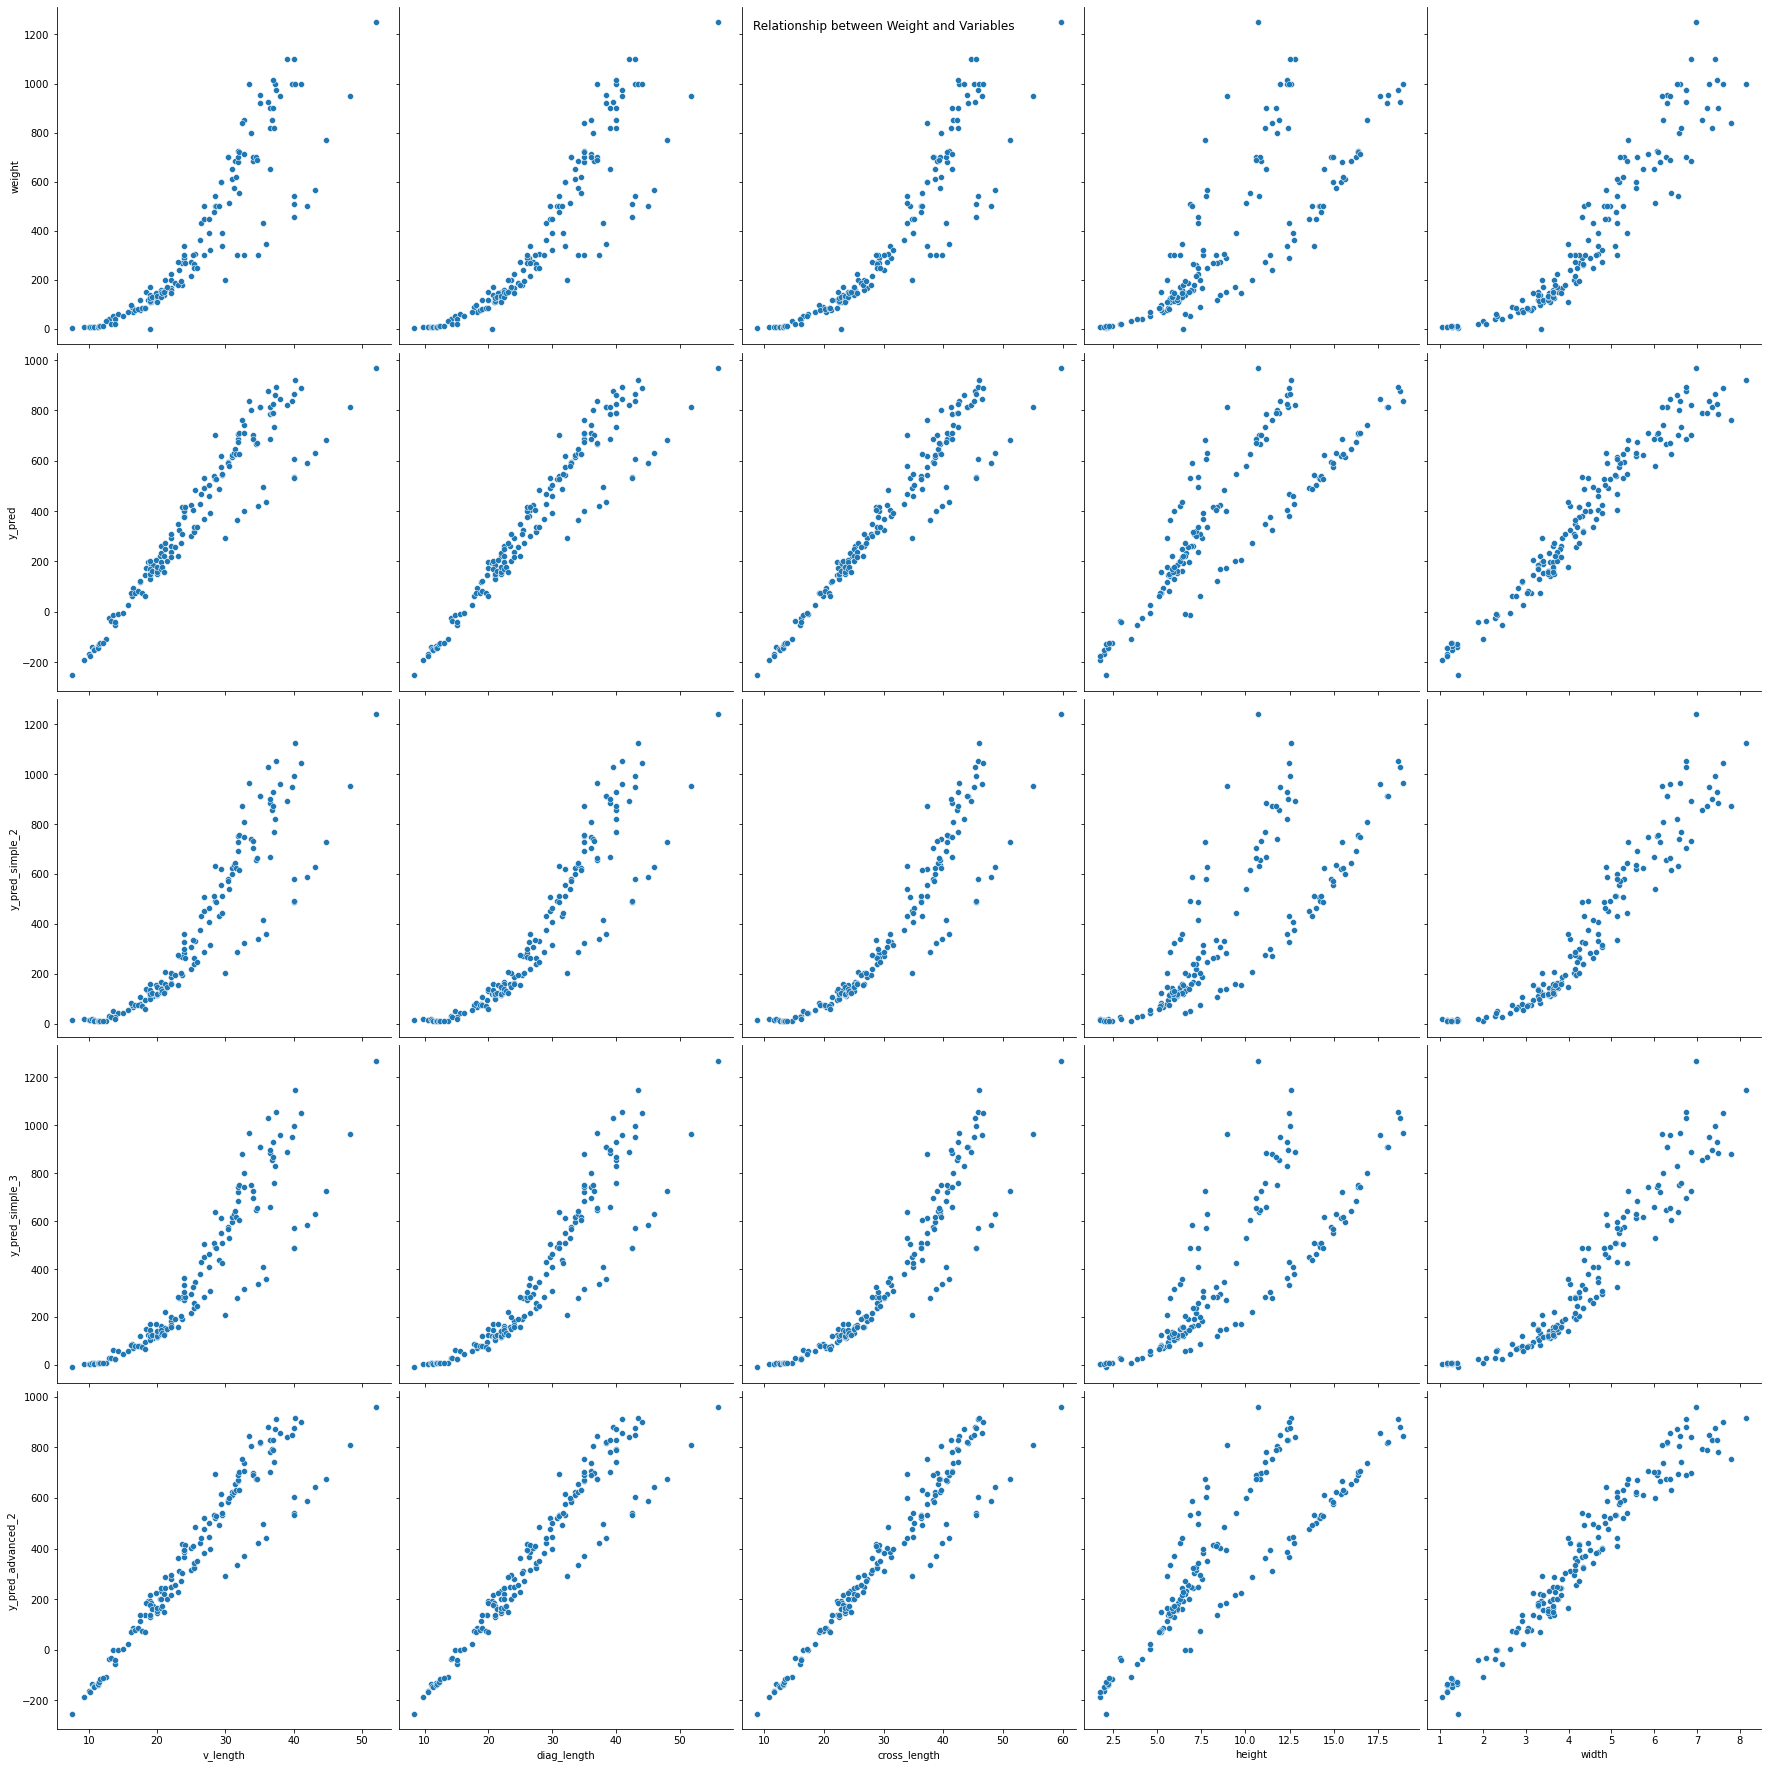

In [128]:
rel_after = sns.pairplot(new_df, x_vars=new_df.columns[2:7], y_vars=['weight','y_pred','y_pred_simple_2','y_pred_simple_3','y_pred_advanced_2'], height=5)
rel_after.fig.suptitle('Relationship between Weight and Variables')

In [133]:
print('Coefficient of determination of models:')
print('Linear Regression:', r2_LR)
print('Simple Nonlinear Regression with degree=2:', r2_nLR_simple_2)
print('Simple Nonlinear Regression with degree=3:', r2_nLR_simple_3)
print('Advanced Nonlinear Regression with degree=2:', r2_nLR_advanced_2)

Coefficient of determination of models:
Linear Regression: 0.9042544074143881
Simple Nonlinear Regression with degree=2: 0.9805923476213073
Simple Nonlinear Regression with degree=3: 0.9804612082222722
Advanced Nonlinear Regression with degree=2: 0.9094768107410511


- With Linear Regression and Advanced Nonlinear Regression models, although R2 score is above 0.9, predicted weight has negative values which is not reasonable.
- Besides, using `Simple Nonlinear Regression` likely provides better prediction with high R2 score (over 0.98) with no negative predicted weight. The sample distribution after prediction over each feature has similarity with actual distribution.